# **Reinforecement Learning - Connect4**


### Deep Q-learning

---

We'll now use all our gained knowledge from the TicTacToe experiments in another game: Connect4!  

TicTacToe is a pretty simple game, with a small state space, and with very little strategy. Connect4 is a bit harder (still not as difficult as Chess\Checkers\Go\Backgammon...).  
For the RL agent, we'll use the deep Q-learning player previously seen. Why so when we saw that the tabular Q-learning player achieved better results in TicTacToe? Because even for a simple game as Connect4, the Q-table is way too large to handle with. This has two effects:
- Big space complexity for the player - it must save a table containing Q-values for each state-action pair.
- Sparsity of the samples - due to the big state space, each state will be visited a small amount of times during training, so that our player won't be able to collect enough experience to learn the actual state-action value.

The strength of deep Q-learning comes in handy with solving these two problems:
- The space complexity of the model is constant - we're not saving a value for each state-action pair, but rather using a fixed amount of weights to approximate this value. This makes the learning process scalable.
- Since we're using a convolutional network and our input is actually an image of the board, we're hoping that the network may learn to generalize states that it has seen and learnt and deduce into states that it hasn't seen (or has but not enough).  

But enough talk, let's try and see if all of the above actually works.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd ./drive/My\ Drive/RL

Mounted at /content/drive
/content/drive/My Drive/RL


In [ ]:
from Connect4.Connect4 import Connect4State, N_ROWS, N_COLS, N_CH
from Players.HumanPlayer import HumanPlayer
from Players.MaxminPlayer import MaxminPlayer
from Players.DQPlayer import DQPlayer, DQNArgs
from Players.RandomPlayer import RandomPlayer
from Players.SemiRandomPlayer import SemiRandomPlayer
from Utility.Auxiliary import *
%matplotlib inline

---
## **Learning**

We'll train our Deep Q-learning player in the methods that achieved the best results for TicTacToe: Semi-random and Self-play.   
For evaluation, as before, we'll test our player against 3 other players:
- 10,000 games against a random player.
- 10 games against a random minimax player, which randomly chooses between all the best actions for *k* turns ahead. We'll use *k=5* because this is empirically a very good player - it took me about 20-30 games to actually manage to win it, all of the others I lost. The down-side is that *k=5* is very time consumable, so we'll have to evaluate only 10 games.
- 2 games against himself.

We'll make ourselves a convinient evaluation function for the above, which will take advantage of the ```evaluate``` function.

In [ ]:
state = Connect4State()

# Evaluation function:
def multi_evaluation(state, player, opponents, nGamesList):
    N = len(opponents)
    pWin1 = [0] * N
    pWin2 = [0] * N
    pTie = [0] * N
    for i, (opp, nGames) in enumerate(zip(opponents, nGamesList)):
        pWin1[i], pWin2[i], pTie[i] = evaluate(state, player, opp, nGames)
    print()
    for i, (opp, nGames) in enumerate(zip(opponents, nGamesList)):
        print("{} vs. {}: P1 Win {:.2f}% | P2 Win {:.2f}% | Tie {:.2f}%".format(player.name, opp.name, pWin1[i] * 100,
                                                                                pWin2[i] * 100, pTie[i] * 100))

We'll initialize some training hyperparameters, some for the neural network itself, some for the training process, and some for the MDP:

In [ ]:
connect4_dqn_args = DQNArgs(ch=N_CH,                            # NN input channels - don't change this!
                            h=N_ROWS,                           # NN input height - don't change this!
                            w=N_COLS,                           # NN input width - don't change this!
                            output_size=N_COLS,                 # NN output size (number of actions) - don't change this!
                            layer_channels=[32, 32, 16],        # number of channels for each layer
                            layer_sizes=[5, 3, 3],              # kernel sizes for each layer
                            layer_strides=[1, 1, 1],            # stride for each layer
                            layer_padding=[0, 1, 1],            # padding for each layer
                            batch_size=32,                      # batch size for optimization step
                            mem_size=100000,                    # replay memory size
                            target_update=5000,                 # training step period for target network update
                            eps_decay=2e4,                      # exploration rate decay
                            lr=0.001,                           # learning rate
                            gamma=0.998)                        # MDP discount factor

### Learning against a semi-random player:

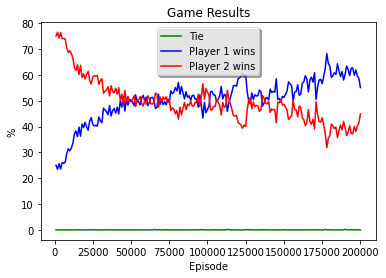

In [ ]:
policy_fileName = "./Connect4/Policies/DQpolicy_vsSemiRand"
nGames = 200000

p1 = DQPlayer("DQ", connect4_dqn_args, isLearning=True)
p2 = SemiRandomPlayer("Random")

log = train(state, p1, p2, nGames=nGames)
plot_log(log)
p1.save_policy(policy_fileName)

In [ ]:
policy_fileName = "./Connect4/Policies/DQpolicy_vsSemiRand"
p1 = DQPlayer("DQ", connect4_dqn_args, isLearning=False)
p1.load_policy(policy_fileName)

p2 = SemiRandomPlayer("Semi-Random")
p3 = MaxminPlayer("Minimax", max_depth=5)
p4 = DQPlayer("DQ2", connect4_dqn_args, isLearning=False)
p4.load_policy(policy_fileName)
opponents = [p2, p3, p4]
nGamesList = [10000, 10, 2]
multi_evaluation(state, p1, opponents, nGamesList)



DQ vs. Semi-Random: P1 Win 61.50% | P2 Win 38.50% | Tie 0.00%
DQ vs. Minimax: P1 Win 0.00% | P2 Win 100.00% | Tie 0.00%
DQ vs. DQ2: P1 Win 50.00% | P2 Win 50.00% | Tie 0.00%


Not looking good enough... No wins against the Minimax player, and almost 16% losses against a semi-random, which indicates that our player did learn how to try and win - but didn't get to the point of making a good look-ahead strategy.

### Learning against himself (self-play):

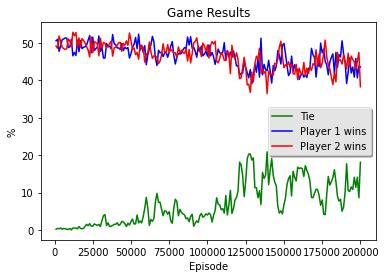

In [ ]:
policy_fileName = "./Connect4/Policies/DQpolicy_selfPlay"
nGames = 200000

p1 = DQPlayer("DQ", connect4_dqn_args, isLearning=True)

log = train(state, p1, p1, nGames=nGames)
plot_log(log)
p1.save_policy(policy_fileName)

I'm actually not so sure on how to read this graph. When dealing with the game of TicTacToe it was clear that our aim was to have the Tie curve grow during the training - bacause it is well-known that two perfect players will always end in a tie in TicTacToe. But in Connect4 this is not necessarily the situation, so maybe this could be good. Though I will note that a graph which bairly changes for 200,000 games shouldn't bear good news.

In [ ]:
policy_fileName = "./Connect4/Policies/DQpolicy_selfPlay"
p1 = DQPlayer("DQ", connect4_dqn_args, isLearning=False)
p1.load_policy(policy_fileName)

p2 = SemiRandomPlayer("Semi-Random")
p3 = MaxminPlayer("Minimax", max_depth=5)
p4 = DQPlayer("DQ2", connect4_dqn_args, isLearning=False)
p4.load_policy(policy_fileName)
opponents = [p2, p3, p4]
nGamesList = [10000, 10, 2]
multi_evaluation(state, p1, opponents, nGamesList)



DQ vs. Semi-Random: P1 Win 63.62% | P2 Win 36.38% | Tie 0.00%
DQ vs. Minimax: P1 Win 0.00% | P2 Win 100.00% | Tie 0.00%
DQ vs. DQ2: P1 Win 50.00% | P2 Win 50.00% | Tie 0.00%


So it seems as though the self-play training achieved fairly similar results to the semi-random, although slightly better.

---
## **Conclusion**
Despite fairly promising theory and results from the Tic Tac Toe part, we didn't manage to achieve any nearly satisfying results. This may be due to many reasons, such as:
- Bad network architecture (too deep/too shallow/too many weights/not enough weights/anything else...)
- Non-tuned hyperparmeters, such as rewards, learning rate, epsilon, decay rate...
- Not enough training, maybe our player just needs to gain more experience in the game and get exposed to more states.
- Not a "fancy" enough algorithm. Although I believe Connect 4 isn't such a hard game, maybe we need a smarter algorithm, and to add more advanced RL techniques.
- Obviously, human-made bugs (my fault :) ).

---
## **Let's play!**

In this section you can try yourself to play against each of the players:  
- ```RandomPlayer(name)``` - A random player.
- ```SemiRandomPlayer(name)``` - A semi-random player, which acts randomly unless given the opportunity to win the game in the next turn.
- ```MaxminPlayer(name, depth)``` - A minimax player which checks `depth` steps forward and uses some heuristic to take the best resulting action. For `depth = 5` this player will be a very good opponent (from my experience playing against it).
- ```DQPlayer(name, connect4_dqn_args, isLearning=False)``` - Our trained Deep Q-learning player with a policy loaded by `load_policy(policy_fileName)`.
- ```HumanPlayer(name)``` - Another human, play against a friend.  

Good luck!



In [ ]:
policy_fileName = "./Connect4/Policies/DQpolicy_selfPlay"
p1 = HumanPlayer("Player")
p2 = DQPlayer("DQ", connect4_dqn_args, isLearning=False)
p2.load_policy(policy_fileName)
game = Game(state, p1, p2)
game.play()
game.reset()

############################################################################################
Connect4
############################################################################################
-----------------------------
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
-----------------------------
Player: Enter desired column (from 0):
3
-----------------------------
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   | x |   |   |   |
-----------------------------
-----------------------------
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |
| o |   |   | x |   |   |   |
-----------------------------
Player: Enter desired column (from 0):
2
---